In [207]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from SimPEG import Mesh
import pandas as pd

from pathlib import Path
import pandas as pd
import fileinput
# import cartopy

In [208]:
!which python

/home/users/ianpg/miniconda3/envs/simpegEM1D-environment/bin/python


In [209]:
datadir = Path('../data/raw_data')
data17dir = datadir.joinpath('AEM_data_2017_avg')
data19dir = datadir.joinpath('AEM_data_2019_avg')

data17 = datadir.joinpath('AEM_data_2017','MCWD3_SCI1i_MOD_dat.xyz')
data19 = datadir.joinpath('AEM_data_2019','MCWD19_SCI8i_MOD_dat.xyz')
df17 = pd.read_csv(data17,header=20,delim_whitespace=True)
df19 = pd.read_csv(data19,header=20,delim_whitespace=True)

df17 = df17.assign(skytem_type=304)
df19 = df19.assign(skytem_type=312)
# df = pd.concat((df17,df19),sort=False)


In [210]:
df = pd.read_pickle(datadir.joinpath('processed_df_1719.pkl'))
line = 100501

df = df.loc[df.skytem_type==312,:]
df =  df.loc[df.LINE_NO==line,:]


ch1_cols = [c for c in df.columns if c.startswith('DBDT_Ch1')]
ch2_cols = [c for c in df.columns if c.startswith('DBDT_Ch2')]
NoGatesLM=28
NoGatesHM=37




msk = df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.
thresh = 10
rm_mask = (df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.).sum(axis=1) > thresh 
remove_inds = rm_mask[rm_mask==True].index
# remove_inds = (msk.sum(axis=1) > thresh).index
df = df.drop(index=np.r_[remove_inds,remove_inds+1])
# df = df.drop(index=remove_inds+1)



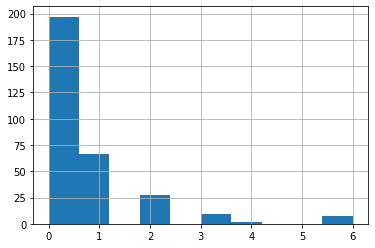

In [211]:
# df = pd.read_pickle(datadir.joinpath('processed_df_1719.pkl'))

(df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.).sum(axis=1).hist()

In [212]:
#TAKE THE LOCATION OF CHANNEL 1 FOR EACH SOUNDING
msk = np.logical_and(df.CHANNEL_NO==1, df.LINE_NO == line)
xy = df.loc[msk,['UTMX', 'UTMY']].values
Line = df.loc[msk,['LINE_NO']].values
dem = df.loc[msk,'ELEVATION'].values[:]
height = df.loc[msk,'INVALT'].values[:]
# height = df.loc[msk,'TX_ALTITUDE'].values[:]
system = df.loc[msk,'skytem_type'].values[:]
rx_locations = np.c_[xy[:,:], height+dem+2.]
src_locations = np.c_[xy[:,:], height+dem]
topo = np.c_[xy[:,:], dem]
skytem_type = df.skytem_type.values

In [213]:
print ( 'msk',msk.shape,'\n'
'xy',xy.shape,'\n'
'Line',Line.shape,'\n'
'dem',dem.shape,'\n'
'height',height.shape,'\n'
'system',system.shape,'\n'
'rx_locations',rx_locations.shape,'\n'
'src_locations',src_locations.shape,'\n'
'topo',topo.shape,'\n'
'skytem_type',skytem_type.shape,'\n')

msk (616,) 
xy (308, 2) 
Line (308, 1) 
dem (308,) 
height (308,) 
system (308,) 
rx_locations (308, 3) 
src_locations (308, 3) 
topo (308, 3) 
skytem_type (616,) 



In [214]:
area = 342
unit_conversion = 1e-12

i_start_hm = 22
i_start_lm = 10

waveform_hm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_312.txt'))
waveform_lm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_312.txt'))
time_input_currents_HM_312 = waveform_hm_312[:,0] 
input_currents_HM_312 = waveform_hm_312[:,1]
time_input_currents_LM_312 = waveform_lm_312[:,0] 
input_currents_LM_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-2.1E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_LM_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312

GateTimeShift=-1.5E-06
MeaTimeDelay=3.5E-04
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_HM_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

In [215]:
times_HM_312

array([0.00049615, 0.00061015, 0.00075415, 0.00093565, 0.00116445,
       0.00145245, 0.00181645, 0.00227545, 0.00285345, 0.00357245,
       0.00445245, 0.00552945, 0.00684745, 0.00846145, 0.01043645])

In [216]:
times_LM_312

array([1.08000e-05, 1.78100e-05, 2.68000e-05, 3.83000e-05, 5.28000e-05,
       7.08000e-05, 9.32900e-05, 1.21290e-04, 1.56790e-04, 2.02290e-04,
       2.59290e-04, 3.31290e-04, 4.22290e-04, 5.36290e-04, 6.80290e-04,
       8.61790e-04, 1.09059e-03, 1.37859e-03])

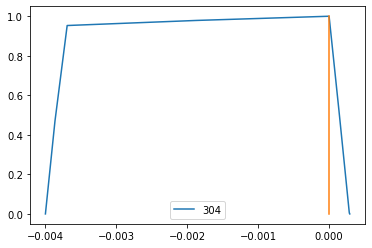

In [217]:
plt.plot(waveform_hm_312[:,0], waveform_hm_312[:,1],label='304')
plt.plot((0, 0), (0, 1))
plt.legend()

In [218]:
times_HM_312

array([0.00049615, 0.00061015, 0.00075415, 0.00093565, 0.00116445,
       0.00145245, 0.00181645, 0.00227545, 0.00285345, 0.00357245,
       0.00445245, 0.00552945, 0.00684745, 0.00846145, 0.01043645])

In [219]:
area = 342
unit_conversion = 1e-12

# i_start_hm = 21
# i_start_lm = 10

waveform_hm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_304.txt'))
waveform_lm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_304.txt'))
time_input_currents_HM_304 = waveform_hm_304[:,0] 
input_currents_HM_304 = waveform_hm_304[:,1]
time_input_currents_LM_304 = waveform_lm_304[:,0] 
input_currents_LM_304 = waveform_lm_304[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-1.8E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_304 = waveform_lm_304[:,0].max()
times_LM_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_304

GateTimeShift=-1.4E-06
MeaTimeDelay=6.000E-05
NoGates=37
t0_hm_304 = waveform_hm_304[:,0].max()
times_HM_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_304    


In [220]:
len(times_HM_304) + len(times_LM_304)
len(times_HM_312) + len(times_LM_312)

33

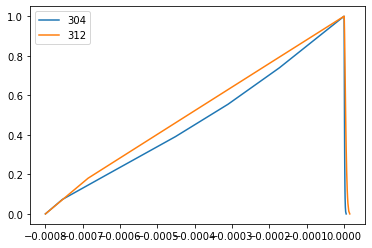

In [221]:
plt.plot(time_input_currents_LM_304, input_currents_LM_304,label='304')
plt.plot(time_input_currents_LM_312, input_currents_LM_312,label='312')
plt.legend()

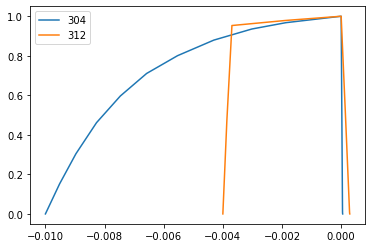

In [222]:
plt.plot(time_input_currents_HM_304, input_currents_HM_304,label='304')
plt.plot(time_input_currents_HM_312, input_currents_HM_312,label='312')
plt.legend()

In [223]:
times_LM_304.shape

(18,)

In [224]:
from SimPEG import (
    Regularization, Directives, Inversion, 
    InvProblem, Optimization, DataMisfit, Utils, Maps
)
from simpegEM1D import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, 
    get_vertical_discretization_time, EM1DSurveyTD,
    get_2d_mesh, LateralConstraint, 
)
from pymatsolver import PardisoSolver
hz_312 = np.loadtxt(datadir.joinpath('AEM_data_2019','thickness.txt'))
hz_304 = np.loadtxt(datadir.joinpath('AEM_data_2017','thickness.txt'))


hz = hz_304
# hz = np.unique(hz_312.values[inds_312,:])* 0.3048
# hz = np.unique(hz_304.values[inds_304,:])* 0.3048
n_sounding = xy.shape[0]
mesh = get_2d_mesh(n_sounding, hz)

In [225]:
588*45

26460

In [226]:
# n_sounding = n_sounding_312 + n_sounding_304
mesh = get_2d_mesh(n_sounding, hz)
# rx_locations = np.vstack((rx_locations_312, rx_locations_304))
# src_locations = np.vstack((src_locations_312, src_locations_304))
# topo = np.vstack((topo_312, topo_304))

times = []
time_dual_moment = []
input_currents = []
time_input_currents = []
input_currents_dual_moment = []
time_input_currents_dual_moment = []

for i_sounding in range(n_sounding):
    if system[i_sounding]==312:
        times.append(times_HM_312)
        time_dual_moment.append(times_LM_312)
        time_input_currents.append(time_input_currents_HM_312)
        input_currents.append(input_currents_HM_312)
        time_input_currents_dual_moment.append(time_input_currents_LM_312)
        input_currents_dual_moment.append(input_currents_LM_312)  
    elif system[i_sounding]==304:
        times.append(times_HM_304)
        time_dual_moment.append(times_LM_304)
        time_input_currents.append(time_input_currents_HM_304)
        input_currents.append(input_currents_HM_304)
        time_input_currents_dual_moment.append(time_input_currents_LM_304)
        input_currents_dual_moment.append(input_currents_LM_304)      

In [227]:
import simpegEM1D

In [228]:
np.hstack(times).size + np.hstack(time_dual_moment).size

10164

In [229]:
# print(survey.nD)
# print(src_locations.shape)
# print(n_sounding)
# print(len(time)*len(time[0]) + len(time_dual_moment)*len(time_dual_moment[0]))
# print(uncert.shape)

In [230]:
mapping = Maps.ExpMap(mesh)

survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations[:,:],
    src_locations = src_locations[:,:],    
    topo = topo[:,:],
    time = times,
    time_dual_moment = time_dual_moment,
    src_type = np.array(["VMD"], dtype=str).repeat(n_sounding),
    rx_type = np.array(["dBzdt"], dtype=str).repeat(n_sounding),    
    offset = np.array([13.25], dtype=float).repeat(n_sounding).reshape([-1,1]),    
    wave_type = np.array(["general"], dtype=str).repeat(n_sounding),    
    field_type = np.array(["secondary"], dtype=str).repeat(n_sounding),    
    input_currents=input_currents,
    time_input_currents=time_input_currents,
    base_frequency = np.array([30.]).repeat(n_sounding),
    input_currents_dual_moment=input_currents_dual_moment,
    time_input_currents_dual_moment=time_input_currents_dual_moment,
    base_frequency_dual_moment = np.array([210.]).repeat(n_sounding),
    moment_type=np.array(["dual"], dtype=str).repeat(n_sounding)
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=mapping, hz=hz, parallel=True, n_cpu=4,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Set parameters
>> Use multiprocessing for parallelization
>> n_cpu: 4


In [231]:
len(xy)

308

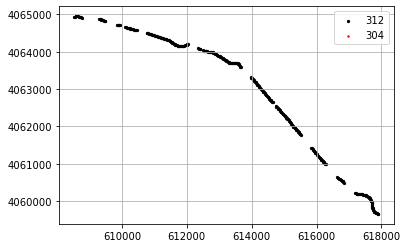

In [232]:
plt.scatter(xy[system==312,0], xy[system==312,1], s=5, c='k',label='312')
plt.scatter(xy[system==304,0], xy[system==304,1], s=2, c='r',label='304')
plt.legend()
plt.gca().grid(True)

In [258]:
ch1_cols = [c for c in df.columns if c.startswith('DBDT_Ch1')]
ch2_cols = [c for c in df.columns if c.startswith('DBDT_Ch2')]

In [261]:
ch2_cols[i_start_hm:]

['DBDT_Ch2GT23',
 'DBDT_Ch2GT24',
 'DBDT_Ch2GT25',
 'DBDT_Ch2GT26',
 'DBDT_Ch2GT27',
 'DBDT_Ch2GT28',
 'DBDT_Ch2GT29',
 'DBDT_Ch2GT30',
 'DBDT_Ch2GT31',
 'DBDT_Ch2GT32',
 'DBDT_Ch2GT33',
 'DBDT_Ch2GT34',
 'DBDT_Ch2GT35',
 'DBDT_Ch2GT36',
 'DBDT_Ch2GT37']

In [234]:
# i_start_hm = 13
# i_start_lm = 10

lm_inds = np.array(['DBDT_Ch1' in key.split('GT') for key in df.keys()], dtype=bool)
hm_inds = np.array(['DBDT_Ch2' in key.split('GT') for key in df.keys()], dtype=bool)
lm_header = (df.keys()[lm_inds])[i_start_lm:]
hm_header = (df.keys()[hm_inds])[i_start_hm:]
data_hm = df.loc[np.logical_and(df.CHANNEL_NO==2, df.LINE_NO == line),hm_header].values[:,:]
data_lm = df.loc[np.logical_and(df.CHANNEL_NO==1, df.LINE_NO == line),lm_header].values[:,:]

# dobs = np.hstack((data_hm, data_lm)).flatten() * unit_conversion

In [235]:
floor_hm = 0.
floor_lm = 0.
std = 0.05
data_hm[np.isnan(data_hm)] = 9999.
data_lm[np.isnan(data_lm)] = 9999.
dobs = np.hstack((data_hm/area, data_lm/area)).flatten()
uncert = np.hstack((abs(data_hm/area)*std + floor_hm, abs(data_lm/area)*std + floor_lm)).flatten()
survey.dobs = -dobs.copy() 
inactive_inds = dobs==9999./area
uncert[inactive_inds] = np.Inf

In [236]:
tmp = dobs.copy()
tmp[inactive_inds] = np.nan
DOBS = tmp.reshape((survey.n_sounding, times_HM_312.size+times_LM_312.size))

In [237]:
DOBS_HM = DOBS[:,:times_HM_312.size]
DOBS_LM = DOBS[:,times_HM_312.size:]

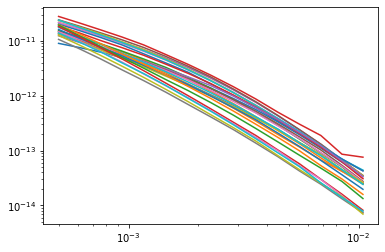

In [238]:
for ii in range(1, 300, 10):
    plt.loglog(times_HM_312, DOBS_HM[ii,:])

In [239]:
# for ii in range(10):
#     plt.sem(DOBS[:,ii], '-')

In [240]:
print('survey.nD size',survey.nD)
print('uncert size',uncert.size)

survey.nD size 10164
uncert size 10164


In [241]:
# output_dir = Path("/scratch/users/ianpg/timelapseAEM/l2-1719-s{}x{}y{}/"
#                   .format(int(100*alpha_s),int(100*alpha_x),int(100*alpha_y)))


In [242]:
# s = (1e-2,1e-2,10,)
# x = (1e-2,10., 1.,)
# y = (1e-2,1.,  1.,)  
# for alpha_s,alpha_x,alpha_y in zip(s,x,y):
alpha_s,alpha_x,alpha_y = (1., 10., 1. )
output_dir = Path("/scratch/users/ianpg/timelapseAEM/l2-1719-s{}x{}y{}/"
                  .format(int(100*alpha_s),int(100*alpha_x),int(100*alpha_y)))

mesh = get_2d_mesh(n_sounding, hz)
m0 = np.ones(mesh.nC) * np.log(1./20.)
regmap = Maps.IdentityMap(mesh)

# mapping is required ... for IRLS
reg = LateralConstraint(
    mesh, mapping=regmap,
    alpha_s =  alpha_s,
    alpha_x =  alpha_x,
    alpha_y =  alpha_y,    
)
reg.get_grad_horizontal(xy[:,:], hz, dim=3, use_cell_weights=True, minimum_distance=1e3)

np.random.seed(1)
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./uncert

opt = Optimization.ProjectedGNCG(maxIter = 10, maxIterCG=20)
# opt.upper = m_upper
# opt.lower = m_lower
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit(chifact=1.)
save_model = Directives.SaveOutputDictEveryIteration(directory=output_dir.as_posix())
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target, save_model])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
try:
    save_model.outDict = {}
except:
    pass

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [243]:
# fig = plt.figure(figsize=(6, 4))
# tri = reg.get_grad_horizontal(topo[:,:2], hz,minimum_distance=1000)
# # plt.plot(topo_312[:,0], topo_312[:,1], 'o')
# # plt.plot(topo_304[:,0], topo_304[:,1], 'o')
# # plt.legend(("SkyTEM312", "SkyTEM304"))
# plt.triplot(topo[:,0], topo[:,1], tri.simplices, color='grey')
# plt.show()

In [244]:
mopt = inv.run(m0)
import local_utils
local_utils.save_obj(save_model.directory,save_model.outDict,'outDict')

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2020-02-24-18-37.npz'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.61e+00  4.49e+05  0.00e+00  4.49e+05    1.12e+04      0              
   1  1.31e+00  9.71e+04  1.83e+04  1.21e+05    1.46e+04      0              
   2  6.53e-01  1.19e+04  2.28e+04  2.68e+04    2.38e+03      0              
   3  3.26e-01  6.72e+03  2.36e+04  1.44e+04    1.19e+03      0              
   4  1.63e-01  5.92e+03  2.48e+04  9.96e+03    1.49e+03      0              
-----------------

In [245]:
target.target

5082.0

In [246]:
mopt = mopt2.copy()

In [198]:
# mref1 = np.ones(mesh.nC) *np.log(1./10.)
# mref2 = np.ones(mesh.nC) *np.log(1./20.)
# def doi_index(m1, m2, mref1, mref2):
#     return abs((m1-m2) / (mref1-mref2))

In [199]:
# doi = doi_index(m1, m2, mref1, mref2)

In [200]:
# phi_d = np.zeros(len(outDict))
# phi_m = np.zeros(len(outDict))
# for ii in range(1, len(outDict)+1, 1):
#     phi_d[ii-1] = outDict[ii]['phi_d']
#     phi_m[ii-1] = outDict[ii]['phi_m']    

In [201]:
# plt.semilogy(phi_d, '.-')
# # plt.semilogy(phi_m, '.-')

In [247]:
import local_utils
outDict = local_utils.load_obj(output_dir,'outDict')

/home/users/ianpg/miniconda3/envs/simpegEM1D-environment/lib/python3.8/site-packages/simpegEM1D/IO.py:54: UserWarning: code under construction - API might change in the future
  warnings.warn(


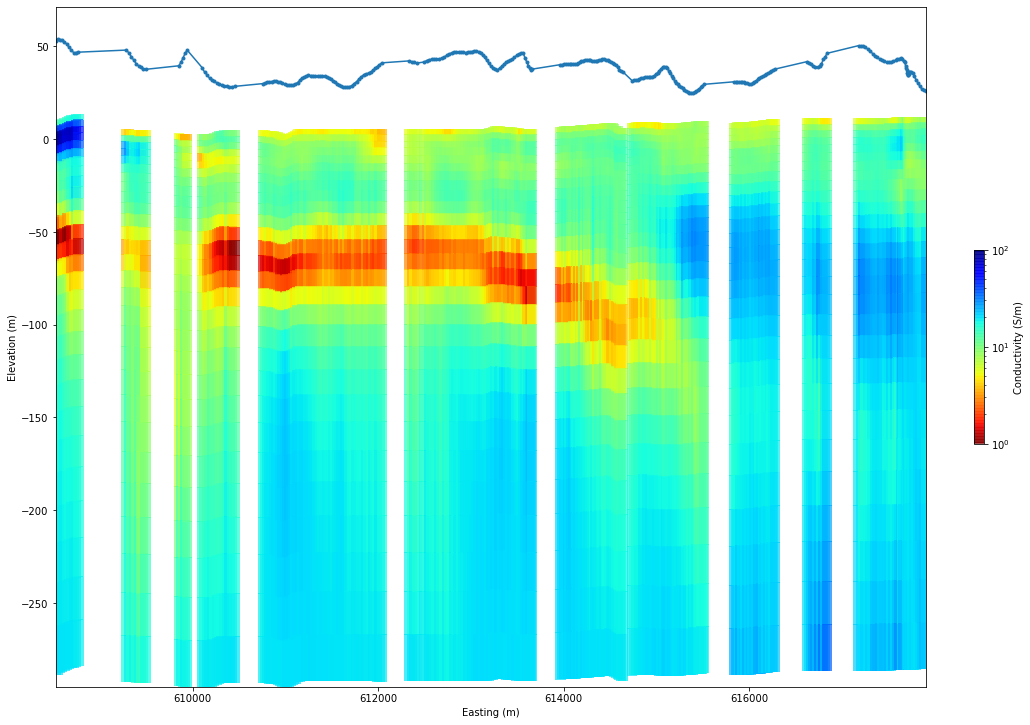

In [248]:
from matplotlib.colors import LogNorm
from simpegEM1D import ModelIO
nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[:,:], 
    physical_property=1./np.exp(Utils.mkvc(mopt.reshape((hz.size, n_sounding), order='F')[:,::nskip])),
    line=np.repeat(line, n_sounding)[::nskip].astype(float)
)

IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r', aspect=20, clim=(1, 100), dx=50, i_line=0)
plt.plot(xy[:,0],height[:],'.-',label='inv')


In [249]:
from matplotlib.colors import LogNorm
from simpegEM1D import ModelIO
nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[:,:], 
    physical_property=1./np.exp(Utils.mkvc(m2.reshape((hz.size, n_sounding), order='F')[:,::nskip])),
    line=np.repeat(line, n_sounding)[::nskip].astype(float)
)

IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r', aspect=20, clim=(1, 100), dx=50, i_line=0)
plt.plot(xy[:,0],height[:],'.-',label='inv')


ValueError: cannot reshape array of size 8990 into shape (29,308)

/home/users/ianpg/miniconda3/envs/simpegEM1D-environment/lib/python3.8/site-packages/simpegEM1D/IO.py:54: UserWarning: code under construction - API might change in the future
  warnings.warn(


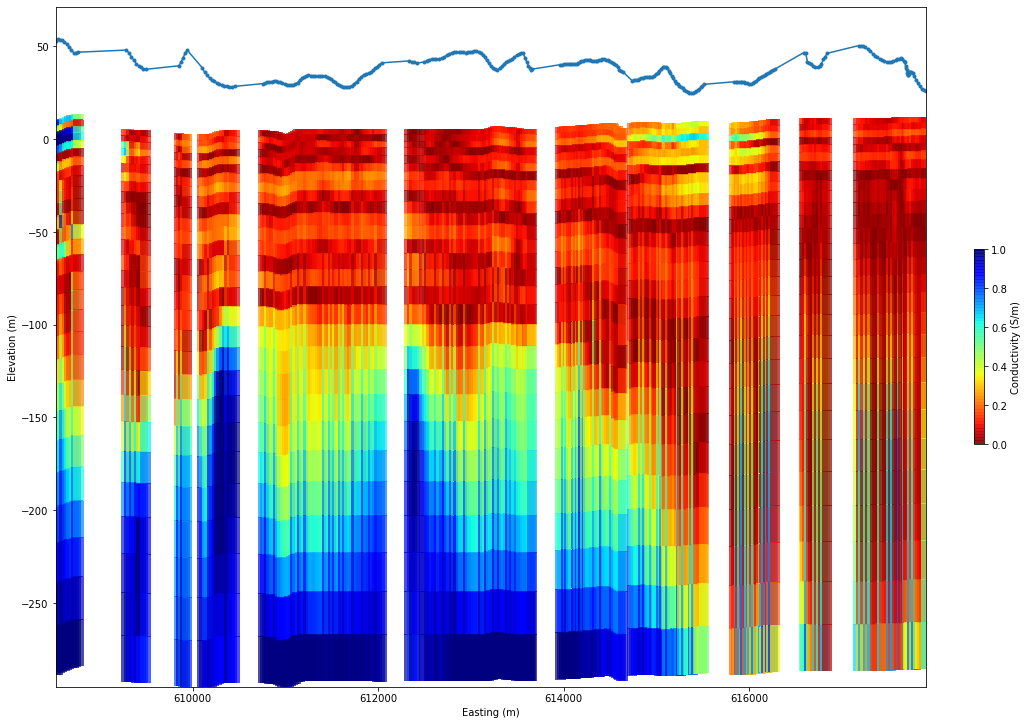

In [205]:
from matplotlib.colors import LogNorm
from simpegEM1D import ModelIO
nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[:,:], 
    physical_property=doi,
    line=np.repeat(line, n_sounding)[::nskip].astype(float)
)

IO.plot_section(line_direction='x', scale='linear', plot_type='pcolor', cmap='jet_r', aspect=20, clim=(0, 1), dx=50, i_line=0)
plt.plot(xy[:,0],height[:],'.-',label='inv')


In [181]:
from matplotlib.colors import LogNorm
from simpegEM1D import ModelIO
outDict = save_model.outDict
mopt_ind = len(outDict)
mopt_ind = 9
nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[:,:], 
    physical_property=1./np.exp(Utils.mkvc(outDict[mopt_ind]['m'].reshape((hz.size, n_sounding), order='F')[:,::nskip])),
    line=np.repeat(line, n_sounding)[::nskip].astype(float)
)

IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r', aspect=20, clim=(1, 100), dx=20, i_line=0)
plt.plot(xy[:,0],height[:],'.-',label='inv')


KeyError: 9

In [250]:
dpred = survey.dpred(mopt)

In [251]:
tmp = dobs.copy()
tmp[inactive_inds] = np.nan
DOBS = tmp.reshape((survey.n_sounding, times_HM_312.size+times_LM_312.size))
DOBS_HM = DOBS[:,:times_HM_312.size]
DOBS_LM = DOBS[:,times_HM_312.size:]

In [252]:
# tmp = invProb.dpred.copy()
tmp = dpred.copy()
tmp[inactive_inds] = np.nan
DPRED = tmp.reshape((survey.n_sounding, times_HM_312.size+times_LM_312.size))
DPRED_HM = DPRED[:,:times_HM_312.size]
DPRED_LM = DPRED[:,times_HM_312.size:]

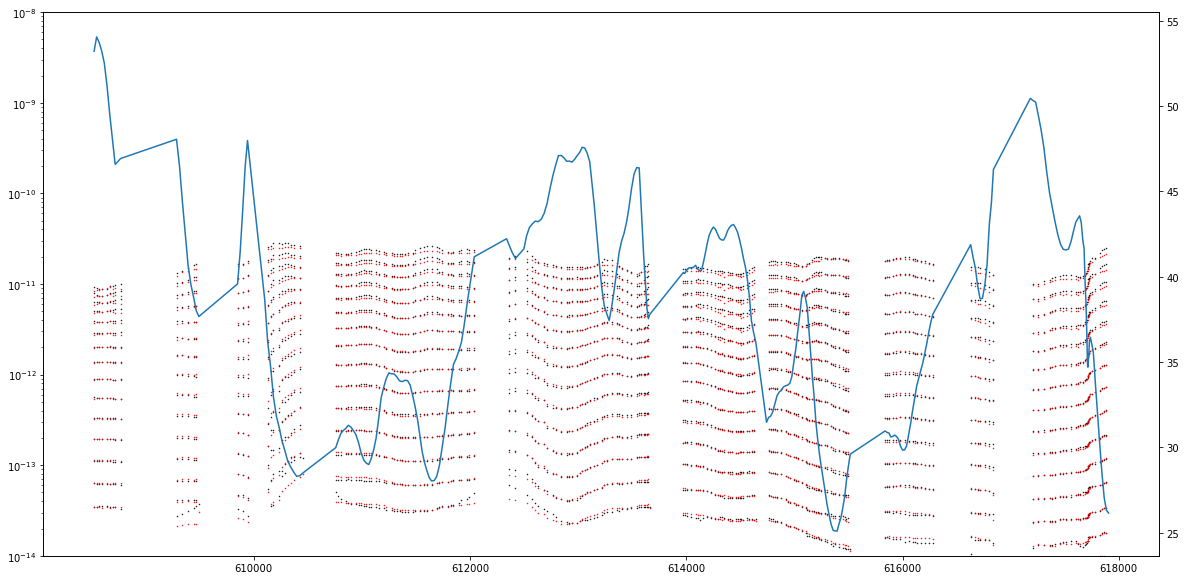

In [253]:
ii = 9
fig, ax = plt.subplots(1,1, figsize=(20, 10))
out = plt.semilogy(xy[:,0], abs(DOBS_HM[:,:]), 'k.', ms=1)
out = plt.semilogy(xy[:,0], abs(DPRED_HM[:,:]), 'r.', ms=1)
ax_1 = ax.twinx()
ax.set_ylim(1e-14, 1e-8)
ax_1.plot(xy[:,0],height)

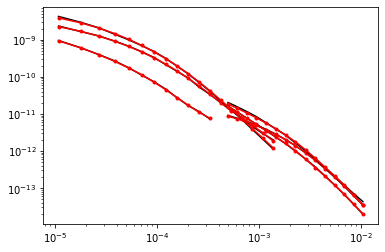

In [254]:
for ii in range(1, 300, 100):
    plt.loglog(times_HM_312, DOBS_HM[ii,:],'k-')
    plt.loglog(times_LM_312, DOBS_LM[ii,:],'k-')
    
    plt.loglog(times_HM_312, -DPRED_HM[ii,:],'r.-')
    plt.loglog(times_LM_312, -DPRED_LM[ii,:],'r.-')

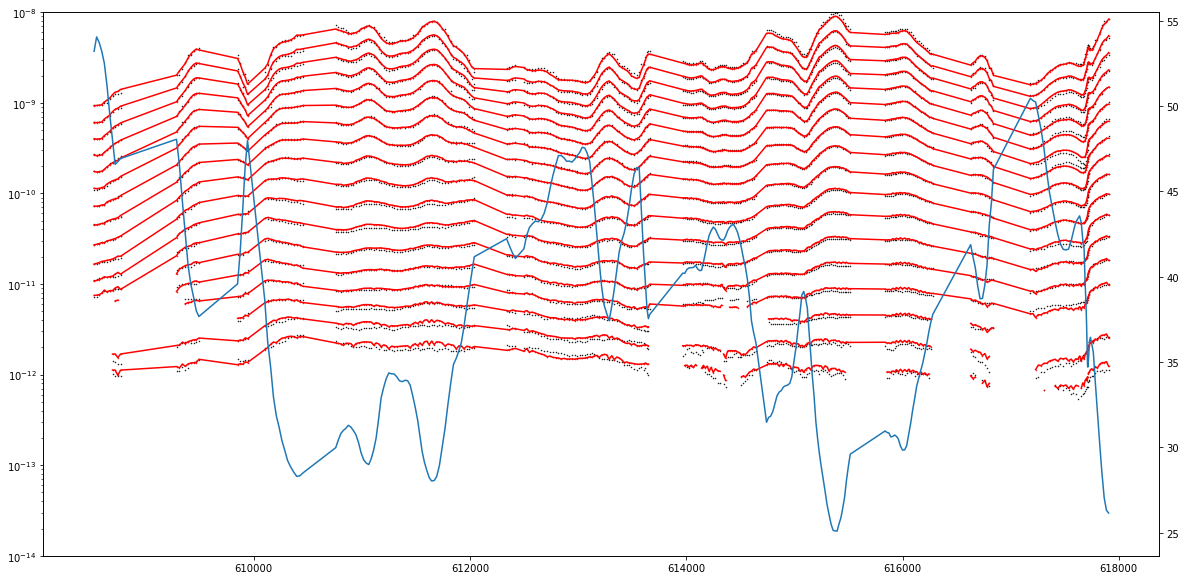

In [255]:

fig, ax = plt.subplots(1,1, figsize=(20, 10))
out = plt.semilogy(xy[:,0], abs(DOBS_LM[:,:]), 'k.', ms=1)
out = plt.semilogy(xy[:,0], abs(DPRED_LM[:,:]), 'r.-', ms=1)
ax_1 = ax.twinx()
ax.set_ylim(1e-14, 1e-8)
ax_1.plot(xy[:,0],height)



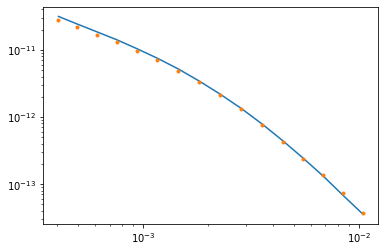

In [112]:
# for ii in range(0, 500, 10):
ii = 50
plt.loglog(times_HM_312, DOBS_HM[ii,:])
plt.loglog(times_HM_312, -DPRED_HM[ii,:], '.')    

In [50]:
# dopt = survey.dpred(mopt)
# dpred = survey.dpred(m0)


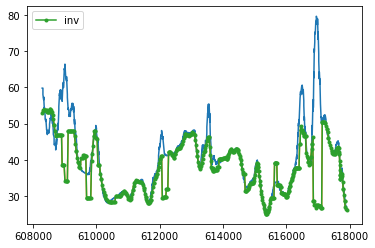

In [51]:
plt.plot(df.loc[df.LINE_NO==line,'UTMX'],df.loc[df.LINE_NO==line,'TX_ALTITUDE'])
plt.plot(df.loc[df.LINE_NO==line,'UTMX'],df.loc[df.LINE_NO==line,'INVALT'])

plt.plot(xy[:,0],height[:],'.-',label='inv')

plt.legend()

(1e-14, 1e-08)

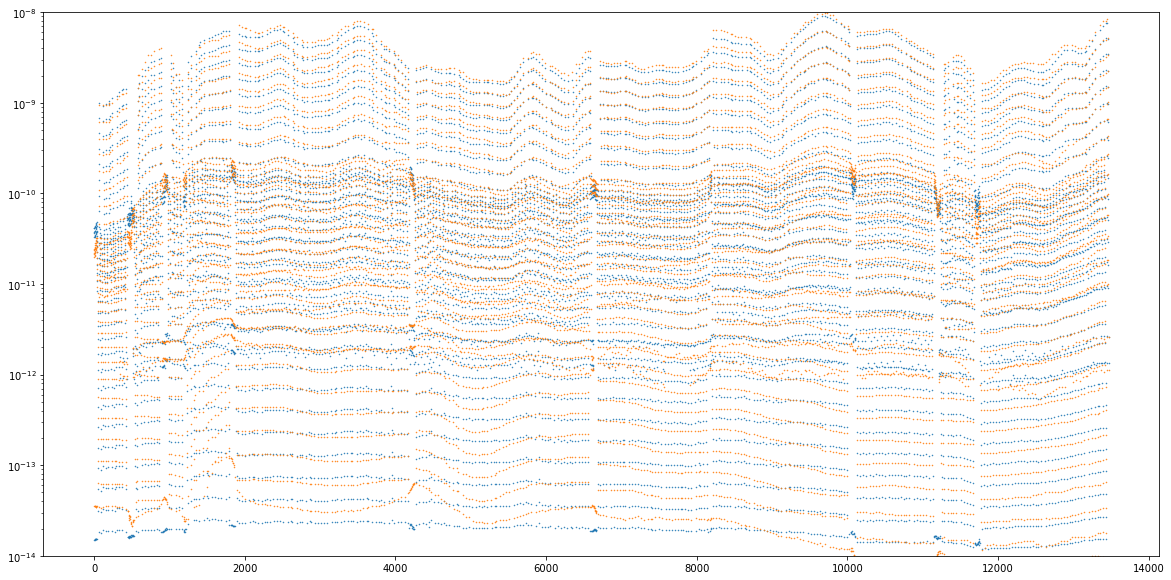

In [52]:
fig = plt.figure(figsize=(20, 10))
plt.semilogy(abs(outDict[mopt_ind]['dpred'][~inactive_inds]), '.', ms=1)
plt.semilogy(abs(survey.dobs[~inactive_inds]), '.', ms=1)
plt.ylim(1e-14, 1e-8)



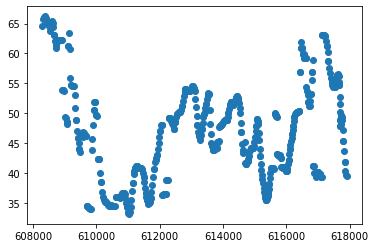

In [53]:
plt.scatter(xy[:,0],src_locations[:,2])

In [54]:
from matplotlib.colors import LogNorm
from simpegEM1D import ModelIO
nskip = 1
i_iter = 1
IO = ModelIO(
    hz=hz,
    topography=topo[1:,:], 
    physical_property=1./np.exp(Utils.mkvc(save_model.outDict[i_iter]['m'].reshape((hz.size, n_sounding), order='F')[:,::nskip])),
    line=np.repeat(line, n_sounding)[::nskip].astype(float)
)

IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r', aspect=20, clim=(1, 100), dx=250, i_line=0)

/home/users/ianpg/miniconda3/envs/simpegEM1D-environment/lib/python3.8/site-packages/simpegEM1D/IO.py:54: UserWarning: code under construction - API might change in the future
  warnings.warn(


ValueError: cannot reshape array of size 17052 into shape (29,587)

In [ ]:
from matplotlib.colors import LogNorm
from simpegEM1D import ModelIO
anim_dir = output_dir.joinpath('animation')
if not anim_dir.exists():
    anim_dir.mkdir()
    
    
nskip = 1
i_iter = 15
nskip = 1

for i_iter in range(1,mopt_ind+1):
    f,ax = plt.subplots(1,figsize=(7.5,4))
    IO = ModelIO(
        hz=hz,
        topography=topo[:,:], 
        physical_property=1./np.exp(Utils.mkvc(save_model.outDict[i_iter]['m'].reshape((hz.size, n_sounding), order='F')[:,::nskip])),
        line=np.repeat(line, n_sounding)[::nskip].astype(float)
    )

    output = IO.plot_section(line_direction='x', scale='log', plot_type='pcolor',
                    cmap='jet_r', aspect=20, clim=(1, 100), dx=250, i_line=0,ax=ax)
    ax.set_title('iteration {}'.format(i_iter))
    cb = output[2]
    cb.set_label('Resistivity ($\Omega$-m)')
    plt.savefig(anim_dir.joinpath('anim_{it:03d}'.format(it=i_iter)),dpi=200,bbox_inches='tight')
#     print('{foo:03d}'.format(foo=n))

In [ ]:
[v for v in anim_dir.iterdir()]